# Testing Regression on Attractiveness Data

## Creating Facial Detection Function facial_detection(impath, margin)

In [3]:
from mtcnn import MTCNN
import PIL

def facial_detection(impath, margin):
    pixels = plt.imread(impath)
    img = PIL.Image.open(impath)
    
    detector = MTCNN()
    face = detector.detect_faces(pixels)

    box = face[0]["box"]

    # Original Face Shape
    x = max(box[0] - margin, 0)
    y = max(box[1] - margin, 0)
    width = min(box[2] + 2 * margin, img.width - x)
    height = min(box[3] + 2 * margin, img.height - y)

    center = (x + (width / 2), y + (height / 2))

    # Square Face Shape
    x = center[0] - (height / 2)
    y = center[1] - (height / 2)
    right = x + height
    bottom = y + height

    cropped_img = img.crop((x, y, right, bottom))
    return cropped_img

## Regression Without Gender Stratification

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import PIL

### Retrieve Data

In [5]:
train_txt = "data/regression_train_test/train_ratings.txt"
test_txt = "data/regression_train_test/test_ratings.txt"

with open(train_txt) as train_ratings:
    train_ratings = train_ratings.readlines()[0]
    train_ratings = np.array(train_ratings.split())
    train_ratings = train_ratings.astype(float)

with open(test_txt) as test_ratings:
    test_ratings = test_ratings.readlines()[0]
    test_ratings = np.array(test_ratings.split())
    test_ratings = test_ratings.astype(float)

print(train_ratings)
print(test_ratings)

[3.433333 2.9      3.966667 ... 3.05     2.4      2.666667]
[2.333333 3.45     2.7      ... 2.533333 4.433333 3.05    ]


In [6]:
img_width = 224
img_height = 224

In [7]:
import PIL

def image_to_tensor(impath):
    img = PIL.Image.open(impath).resize((img_width, img_height))
    img = np.array(img)
    tensor = tf.image.convert_image_dtype(img, dtype=tf.float16, saturate=False, name=None)
    return tensor

In [95]:
import pathlib

train_dir = pathlib.Path("data/all_images_cropped/")
test_dir = pathlib.Path("data/all_images_cropped/")

train_images = list(train_dir.glob("*_train/*.jpg"))
train_images = sorted(train_images, key=lambda x: str(x)[str(x).index("_train")+7:])
test_images = list(test_dir.glob("*_test/*.jpg"))
test_images = sorted(test_images, key=lambda x: str(x)[str(x).index("_test")+6:])

x_train = np.array([image_to_tensor(impath) for impath in train_images])
y_train = train_ratings

x_test = np.array([image_to_tensor(impath) for impath in test_images])
y_test = test_ratings

### Make and Train ResNet152 Model

In [134]:
base_model = tf.keras.applications.ResNet152(input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet")
base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="linear")
])

model.compile(optimizer="adam", loss="mean_squared_error", metrics=["MeanAbsoluteError"])

In [122]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_10 (Dense)            (None, 1)                 2049      
                                                                 
Total params: 58372993 (222.68 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________


In [123]:
# Smaller batch size because I was having an "exploding gradient" problem and I read that smaller batch sizes may help.
history = model.fit(x_train, y_train, batch_size=16, epochs=40, validation_data=(x_test, y_test))

Epoch 1/40
207/207 [==============================] - 539s 3s/step - loss: 0.6782 - mean_absolute_error: 0.6331 - val_loss: 0.4005 - val_mean_absolute_error: 0.5220
Epoch 2/40
207/207 [==============================] - 507s 2s/step - loss: 0.4150 - mean_absolute_error: 0.5247 - val_loss: 0.3810 - val_mean_absolute_error: 0.5012
Epoch 3/40
207/207 [==============================] - 510s 2s/step - loss: 0.4025 - mean_absolute_error: 0.5112 - val_loss: 0.3700 - val_mean_absolute_error: 0.4872
Epoch 4/40
207/207 [==============================] - 505s 2s/step - loss: 0.3973 - mean_absolute_error: 0.5094 - val_loss: 0.3822 - val_mean_absolute_error: 0.4835
Epoch 5/40
207/207 [==============================] - 511s 2s/step - loss: 0.3928 - mean_absolute_error: 0.5032 - val_loss: 0.3575 - val_mean_absolute_error: 0.4804
Epoch 6/40
207/207 [==============================] - 510s 2s/step - loss: 0.3823 - mean_absolute_error: 0.4961 - val_loss: 0.3558 - val_mean_absolute_error: 0.4714
Epoch 7/40

In [124]:
def plot_reg_history(history):
    plt.figure(figsize=(8, 10))

    plt.subplot(2, 1, 1)
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.title('Model Mean Absolute Error')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')

    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

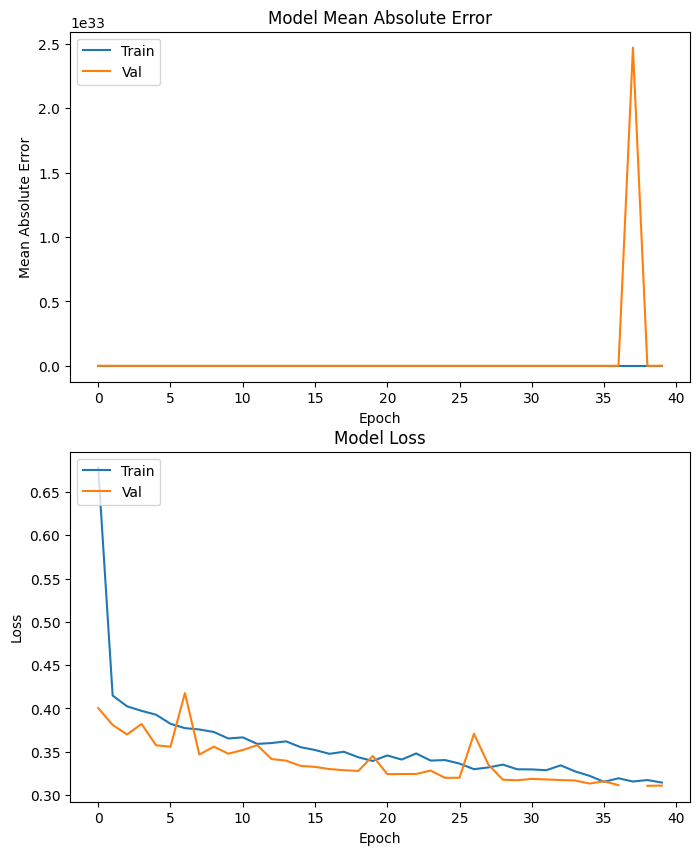

In [125]:
plot_reg_history(history)

In [126]:
def predict_another(impath):
    img = facial_detection(impath, 10).resize((img_width, img_height))
    tensor = tf.image.convert_image_dtype(img, dtype=tf.float16, saturate=False, name=None)
    img_array = np.array([tensor])
    prediction = model.predict(img_array)
    prediction = float(prediction[0][0])
    print(f"This person is most likely a {round(prediction, 2)}")

    return img

In [127]:
def predict_scut(impath):
    img = PIL.Image.open(impath).resize((img_width, img_height))
    path = pathlib.Path(impath)
    index = test_images.index(path)
    actual_rating = test_ratings[index]
    
    tensor = tf.image.convert_image_dtype(img, dtype=tf.float16, saturate=False, name=None)
    img_array = np.array([tensor])
    prediction = model.predict(img_array)
    prediction = float(prediction[0][0])
    print(f"This person is most likely a {round(prediction, 2)}")
    print(f"Actual rating: {actual_rating}")

    return img

1/1 [==============================] - 3s 3s/step
This person is most likely a 3.49


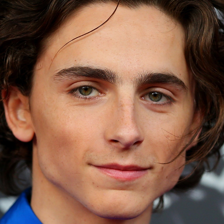

In [128]:
img = predict_another("data/my_images/timothee.jpg")
img

1/1 [==============================] - 0s 219ms/step
This person is most likely a 3.19
Actual rating: 3.85


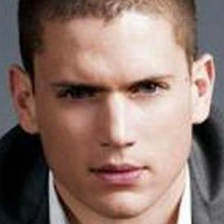

In [129]:
scut_img = predict_scut("data/all_images_cropped/m_test/CM747.jpg")
scut_img

## Regression With Gender Stratification

In [13]:
img_height = 224
img_width = 224

### Retrieve Data

In [107]:
# Just so that the img_height & img_width update
def image_to_tensor(impath):
    img = PIL.Image.open(impath).resize((img_width, img_height))
    img = np.array(img)
    tensor = tf.image.convert_image_dtype(img, dtype=tf.float16, saturate=False, name=None)
    return tensor

In [108]:
def extract_ratings(text_path):
    with open(text_path) as ratings:
        ratings = ratings.readlines()[0]
        ratings = np.array(ratings.split())
        ratings = ratings.astype(float)

    return ratings

In [109]:
m_train_txt = "data/all_images_cropped/m_train_ratings"
f_train_txt = "data/all_images_cropped/f_train_ratings"

m_train_ratings = extract_ratings(m_train_txt)
f_train_ratings = extract_ratings(f_train_txt)

In [110]:
m_test_txt = "data/all_images_cropped/m_test_ratings"
f_test_txt = "data/all_images_cropped/f_test_ratings"

m_test_ratings = extract_ratings(m_test_txt)
f_test_ratings = extract_ratings(f_test_txt)

In [111]:
m_train_dir = pathlib.Path("data/all_images_cropped/m_train")
f_train_dir = pathlib.Path("data/all_images_cropped/f_train")
m_test_dir = pathlib.Path("data/all_images_cropped/m_test")
f_test_dir = pathlib.Path("data/all_images_cropped/f_test")

m_train_images = list(m_train_dir.glob("*.jpg"))
f_train_images = list(f_train_dir.glob("*.jpg"))
m_test_images = list(m_test_dir.glob("*.jpg"))
f_test_images = list(f_test_dir.glob("*.jpg"))

m_x_train = np.array([image_to_tensor(impath) for impath in m_train_images])
m_y_train = m_train_ratings

f_x_train = np.array([image_to_tensor(impath) for impath in f_train_images])
f_y_train = f_train_ratings

m_x_test = np.array([image_to_tensor(impath) for impath in m_test_images])
m_y_test = m_test_ratings

f_x_test = np.array([image_to_tensor(impath) for impath in f_test_images])
f_y_test = f_test_ratings

### ResNet152 Model on Male Only Data

In [19]:
m_base_model = tf.keras.applications.ResNet152(input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet")
m_base_model.trainable = False

m_model = tf.keras.Sequential([
    m_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="linear")
])

m_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["MeanAbsoluteError"])

In [20]:
m_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 58372993 (222.68 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________


In [21]:
m_history = m_model.fit(m_x_train, m_y_train, batch_size=32, epochs=40, validation_data=(m_x_test, m_y_test))

Epoch 1/40
51/51 [==============================] - 292s 6s/step - loss: 1.1614 - mean_absolute_error: 0.8295 - val_loss: 0.4638 - val_mean_absolute_error: 0.4905
Epoch 2/40
51/51 [==============================] - 268s 5s/step - loss: 0.4216 - mean_absolute_error: 0.5086 - val_loss: 0.3929 - val_mean_absolute_error: 0.4803
Epoch 3/40
51/51 [==============================] - 267s 5s/step - loss: 0.4087 - mean_absolute_error: 0.5047 - val_loss: 0.3796 - val_mean_absolute_error: 0.4873
Epoch 4/40
51/51 [==============================] - 262s 5s/step - loss: 0.4036 - mean_absolute_error: 0.4991 - val_loss: 0.3723 - val_mean_absolute_error: 0.4878
Epoch 5/40
51/51 [==============================] - 261s 5s/step - loss: 0.3949 - mean_absolute_error: 0.4977 - val_loss: 0.3729 - val_mean_absolute_error: 0.4659
Epoch 6/40
51/51 [==============================] - 273s 5s/step - loss: 0.3878 - mean_absolute_error: 0.4886 - val_loss: 0.3613 - val_mean_absolute_error: 0.4851
Epoch 7/40
51/51 [====

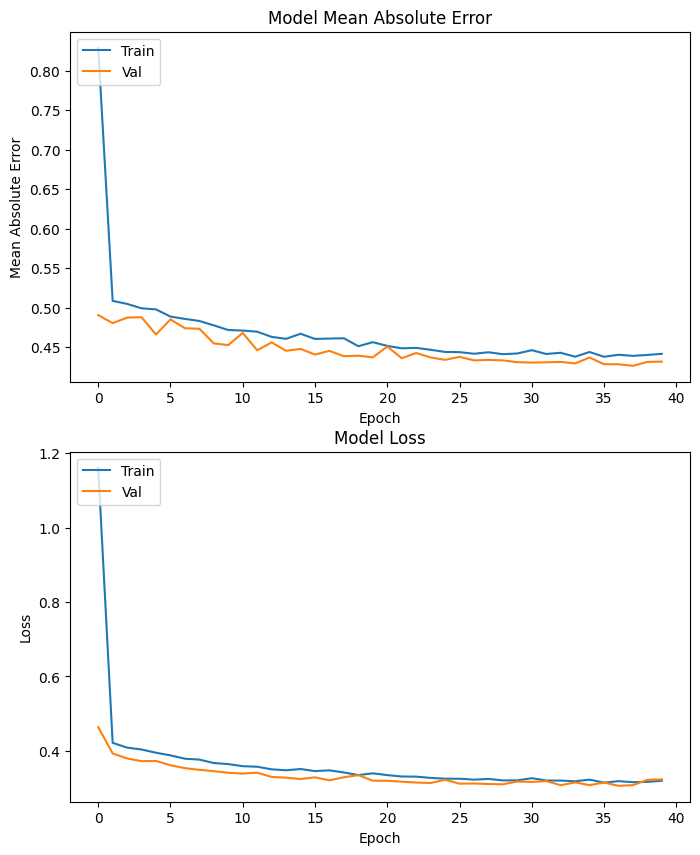

In [22]:
plot_reg_history(m_history)

In [89]:
def predict_another_male(impath):
    img = facial_detection(impath, 10).resize((img_width, img_height))
    tensor = tf.image.convert_image_dtype(img, dtype=tf.float16, saturate=False, name=None)
    img_array = np.array([tensor])
    prediction = m_model.predict(img_array)
    prediction = float(prediction[0][0])
    print(f"This person is most likely a {round(prediction, 2)}")

    return img

In [94]:
def predict_scut_male(impath):
    img = PIL.Image.open(impath).resize((img_width, img_height))
    path = pathlib.Path(impath)
    index = m_test_images.index(path)
    m_actual_rating = m_test_ratings[index]
    
    tensor = tf.image.convert_image_dtype(img, dtype=tf.float16, saturate=False, name=None)
    img_array = np.array([tensor])
    prediction = m_model.predict(img_array)
    prediction = float(prediction[0][0])
    print(f"This person is most likely a {round(prediction, 2)}")
    print(f"Actual rating: {m_actual_rating}")

    return img

1/1 [==============================] - 1s 779ms/step
This person is most likely a 3.32
Actual rating: 4.333333


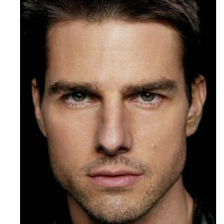

In [95]:
path = pathlib.Path(r"data/all_images_cropped/m_test/CM667.jpg")

m_img = predict_scut_male(path)
m_img

### ResNet152 Model on Female Only Data

In [26]:
f_base_model = tf.keras.applications.ResNet152(input_shape=(img_width, img_height, 3), include_top=False, weights="imagenet")
f_base_model.trainable = False

f_model = tf.keras.Sequential([
    f_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="linear")
])

f_model.compile(optimizer="adam", loss="mean_squared_error", metrics=["MeanAbsoluteError"])

In [27]:
f_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d_2  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_9 (Dense)             (None, 1)                 2049      
                                                                 
Total params: 58372993 (222.68 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 58370944 (222.67 MB)
_________________________________________________________________


In [28]:
f_history = f_model.fit(f_x_train, f_y_train, batch_size=32, epochs=40, validation_data=(f_x_test, f_y_test))

Epoch 1/40
53/53 [==============================] - 254s 5s/step - loss: 1.6668 - mean_absolute_error: 0.9770 - val_loss: 0.4927 - val_mean_absolute_error: 0.5635
Epoch 2/40
53/53 [==============================] - 243s 5s/step - loss: 0.4817 - mean_absolute_error: 0.5679 - val_loss: 0.4537 - val_mean_absolute_error: 0.5485
Epoch 3/40
53/53 [==============================] - 242s 5s/step - loss: 0.4658 - mean_absolute_error: 0.5618 - val_loss: 0.4481 - val_mean_absolute_error: 0.5504
Epoch 4/40
53/53 [==============================] - 248s 5s/step - loss: 0.4629 - mean_absolute_error: 0.5600 - val_loss: inf - val_mean_absolute_error: 564907708073300929455640914427904.0000
Epoch 5/40
53/53 [==============================] - 251s 5s/step - loss: 0.4548 - mean_absolute_error: 0.5553 - val_loss: 0.4368 - val_mean_absolute_error: 0.5434
Epoch 6/40
53/53 [==============================] - 243s 5s/step - loss: 0.4517 - mean_absolute_error: 0.5550 - val_loss: 0.4331 - val_mean_absolute_error: 

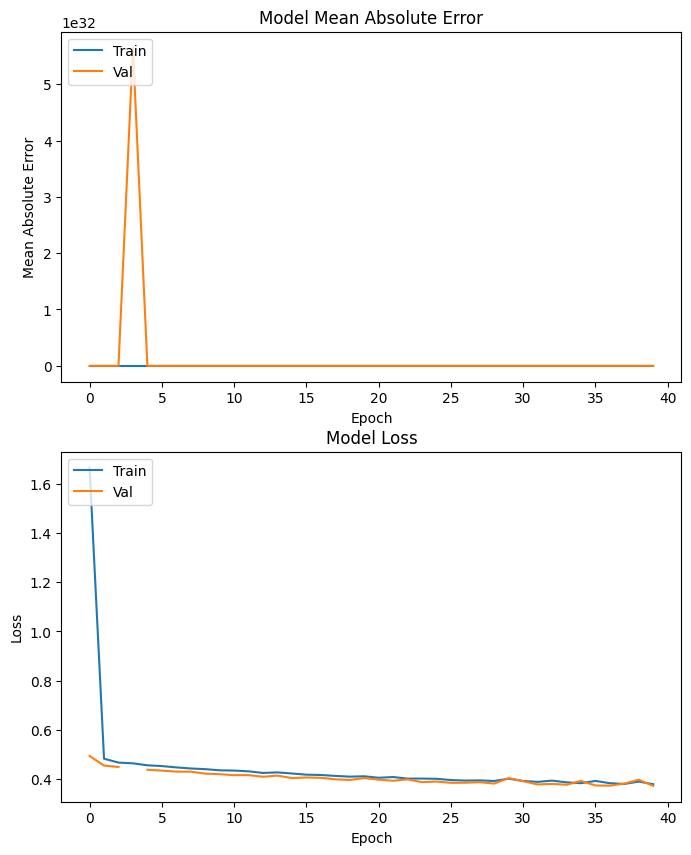

In [29]:
plot_reg_history(f_history)

In [66]:
def predict_another_female(impath):
    img = facial_detection(impath, 10).resize((img_width, img_height))
    tensor = tf.image.convert_image_dtype(img, dtype=tf.float16, saturate=False, name=None)
    img_array = np.array([tensor])
    prediction = f_model.predict(img_array)
    prediction = float(prediction[0][0])
    print(f"This person is most likely a {round(prediction, 2)}")

    return img

In [96]:
def predict_scut_female(impath):
    img = PIL.Image.open(impath).resize((img_width, img_height))
    path = pathlib.Path(impath)
    index = f_test_images.index(path)
    f_actual_rating = f_test_ratings[index]
    
    tensor = tf.image.convert_image_dtype(img, dtype=tf.float16, saturate=False, name=None)
    img_array = np.array([tensor])
    prediction = f_model.predict(img_array)
    prediction = float(prediction[0][0])
    print(f"This person is most likely a {round(prediction, 2)}")
    print(f"Actual rating: {f_actual_rating}")

    return img

1/1 [==============================] - 1s 794ms/step
This person is most likely a 3.43
Actual rating: 3.95


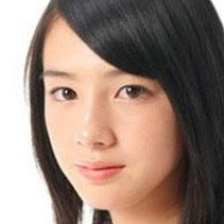

In [97]:
path = r"data/all_images_cropped/f_test/AF2.jpg"

f_img = predict_scut_female(path)
f_img

1/1 [==============================] - 1s 891ms/step
This person is most likely a 3.48


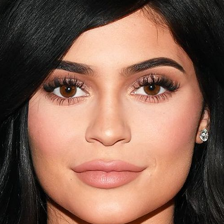

In [102]:
f_img = predict_another_female("data/my_images/kylie.jpg")
f_img

## Results of Resnet Regression

    Generally, Resnet was able to predict attractiveness within ±0.45 of the actual facial rating (MAE 0.45) for both training and validation data. After 40 epochs, the best model was the specifically male-only resnet which achieved 0.44 and 0.43 MAE on the training and validation data respectively. The female-only model did the worst, which may be attributed to suboptimal starting weights for the model.

    The models struggle witht the extremes, however, which is understandable since total (between both men AND women) there are only 16 training images total that round up to a 5 as opposed to 1,590 training images that round to a 3. A solution to this is data augmentation or gathering more data. Data augmentation with these images may be difficult due to all of the other images being upright and all of the faces being cropped to be in roughly the same place by MTCNN facial detection.

    In addition, I believe that with more epochs, these models could reach 0.42 MAE or lower. I don't believe Resnet is the best option to achieve this, however. In hindsight, Resnet was not trained on faces, and therefore is not optimally extracting important facial features in it's convolutional layers. A solution to this would be extracting the image embeddings using Facenet or something similar, then performing regression separately. The underlying concept would still be transfer-learning, but Facenet would theoretically work better on faces.

    Overall, I would consider the Resnet regression on the SCUT data a success. I learned how to use transfer-learning with Resnet to perform regression on data, as well as how to proceed to improve the results of regression on this dataset.

I'm choosing to only save the resnet model that was trained on both genders since it performed well on both and only slightly worse than the male-only model.

In [133]:
model.save("models/resnet_regression_both_44")

INFO:tensorflow:Assets written to: models/resnet_regression_both_44\assets


INFO:tensorflow:Assets written to: models/resnet_regression_both_44\assets
